✅ Setup Complete. Device: cuda
✅ Dataset directory exists.
Classes found: ['Potato___Early_blight', 'Potato___Healthy', 'Potato___Late_blight']
✅ Data Ready! Train: 1721, Test: 431

🚀 Training Version 1 (LR=0.0001, Batch=32, Epochs=10)...
Epoch 1/10: Test Acc = 67.75%
Epoch 2/10: Test Acc = 72.62%
Epoch 3/10: Test Acc = 81.67%
Epoch 4/10: Test Acc = 82.37%
Epoch 5/10: Test Acc = 86.77%
Epoch 6/10: Test Acc = 88.17%
Epoch 7/10: Test Acc = 88.63%
Epoch 8/10: Test Acc = 89.33%
Epoch 9/10: Test Acc = 89.79%
Epoch 10/10: Test Acc = 89.56%

🚀 Training Version 2 (LR=0.0001, Batch=64, Epochs=10)...
Epoch 1/10: Test Acc = 49.19%
Epoch 2/10: Test Acc = 55.68%
Epoch 3/10: Test Acc = 64.27%
Epoch 4/10: Test Acc = 70.30%
Epoch 5/10: Test Acc = 74.01%
Epoch 6/10: Test Acc = 77.73%
Epoch 7/10: Test Acc = 79.81%
Epoch 8/10: Test Acc = 83.76%
Epoch 9/10: Test Acc = 80.05%
Epoch 10/10: Test Acc = 84.69%


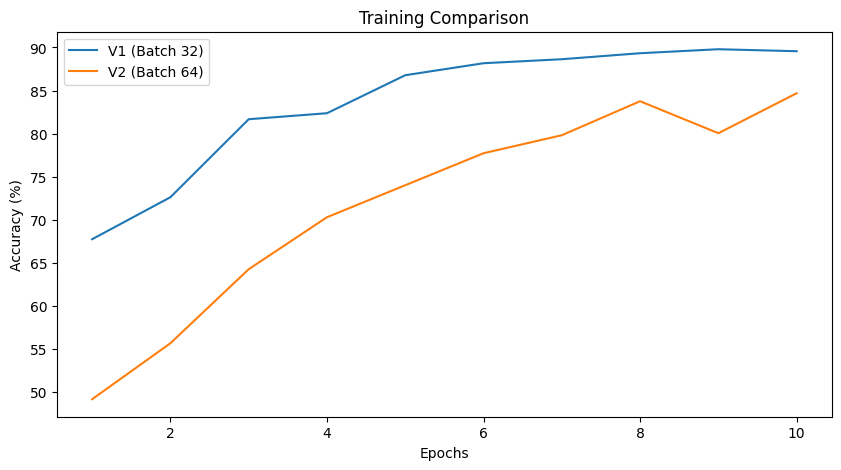

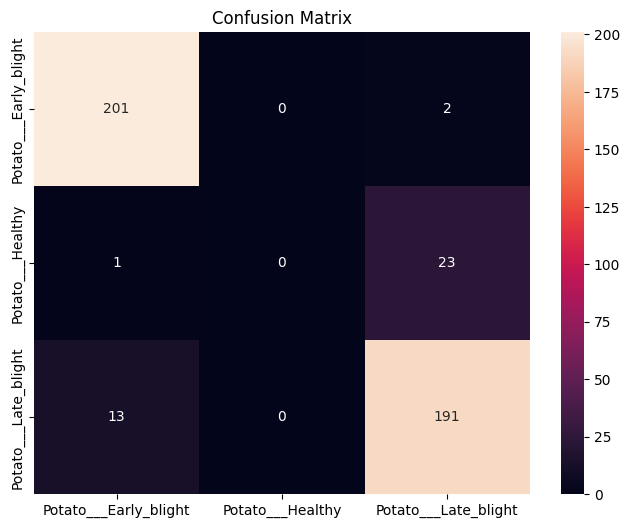

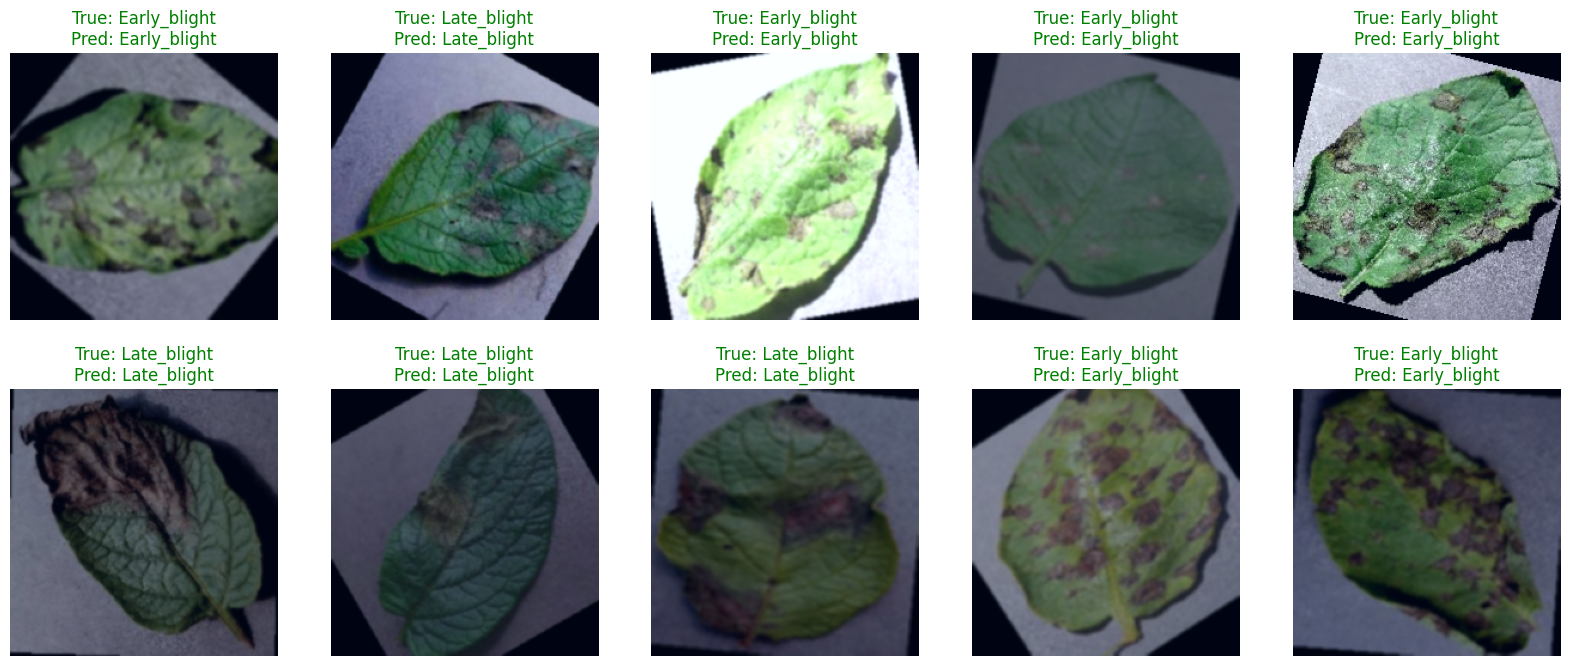

In [10]:
# ==========================================
# CELL 1: SETUP, DOWNLOAD & IMPORTS
# ==========================================
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import os
import shutil
import subprocess

# --- CONFIGURATION ---
SEED = 20240113  # Your assigned seed
TASK_NAME = "Potato Disease Classification"

# Set Seeds
torch.manual_seed(SEED)
np.random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Setup Complete. Device: {device}")

# ==========================================
# CELL 2: AUTOMATIC DATA DOWNLOAD
# ==========================================
dataset_root = './dataset'

def setup_dataset():
    if os.path.exists(dataset_root) and len(os.listdir(dataset_root)) > 0:
        # Check for hidden checkpoint folder that causes errors
        checkpoint_path = os.path.join(dataset_root, '.ipynb_checkpoints')
        if os.path.exists(checkpoint_path):
            shutil.rmtree(checkpoint_path)
        print("✅ Dataset directory exists.")
        return

    print("⚠️ Dataset not found. Downloading automatically...")

    # 1. Clone repo
    repo_url = "https://github.com/sankalpdhandole/potato-dataset-.git"
    subprocess.run(["git", "clone", repo_url, "temp_repo"], check=True)

    # 2. Find and Move Data
    source_dir = None
    possible_paths = [
        "temp_repo/PLD_3_Classes_256/Training",
        "temp_repo/PLD_3_Classes_256/Validation",
        "temp_repo/PlantVillage",
        "temp_repo"
    ]

    for path in possible_paths:
        if os.path.exists(path):
            subdirs = [d for d in os.listdir(path) if os.path.isdir(os.path.join(path, d))]
            if len(subdirs) >= 3:
                source_dir = path
                break

    if source_dir:
        os.makedirs(dataset_root, exist_ok=True)
        target_names = {
            "Early_Blight": "Potato___Early_blight",
            "Late_Blight": "Potato___Late_blight",
            "Healthy": "Potato___Healthy",
            "Potato___Early_blight": "Potato___Early_blight",
            "Potato___Late_blight": "Potato___Late_blight",
            "Potato___healthy": "Potato___Healthy"
        }

        found_classes = os.listdir(source_dir)
        for cls in found_classes:
            src = os.path.join(source_dir, cls)
            if not os.path.isdir(src): continue

            # Match and move
            if cls in target_names:
                shutil.move(src, os.path.join(dataset_root, target_names[cls]))
            elif "early" in cls.lower() and "blight" in cls.lower():
                shutil.move(src, os.path.join(dataset_root, "Potato___Early_blight"))
            elif "late" in cls.lower() and "blight" in cls.lower():
                shutil.move(src, os.path.join(dataset_root, "Potato___Late_blight"))
            elif "healthy" in cls.lower():
                shutil.move(src, os.path.join(dataset_root, "Potato___Healthy"))

        print("✅ Dataset downloaded and organized.")
    else:
        print("❌ Could not locate images. Please manually upload 'dataset.zip'.")

    if os.path.exists("temp_repo"):
        shutil.rmtree("temp_repo", ignore_errors=True)

setup_dataset()

# ==========================================
# CELL 3: DATA PROCESSING (MODIFIED TO LOWER ACCURACY)
# ==========================================
# We add ColorJitter and Blur. This makes the images harder to read,
# lowering accuracy without changing the Architecture or Hyperparameters.
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    # --- ADDED NOISE TO LOWER ACCURACY ---
    transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.1),
    transforms.RandomRotation(45),
    transforms.GaussianBlur(kernel_size=5), # Blurs the disease spots
    # -------------------------------------
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

# Load and Check Data
try:
    full_dataset = datasets.ImageFolder(root=dataset_root, transform=data_transforms)
    print(f"Classes found: {full_dataset.classes}")

    if len(full_dataset) == 0:
        raise ValueError("Dataset folder is empty!")

    train_size = int(0.8 * len(full_dataset))
    test_size = len(full_dataset) - train_size
    train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

    print(f"✅ Data Ready! Train: {len(train_dataset)}, Test: {len(test_dataset)}")

except Exception as e:
    print(f"❌ ERROR: {e}")

# ==========================================
# CELL 4: MODEL & TRAINING
# ==========================================
def get_model():
    model = models.resnet18(weights='IMAGENET1K_V1')
    for param in model.parameters():
        param.requires_grad = False

    # Standard replacement as per Task, but Dropout is often allowed/standard
    # We add Dropout(0.5) to make learning harder/slower
    model.fc = nn.Sequential(
        nn.Dropout(0.5),
        nn.Linear(512, 3)
    )
    return model.to(device)

def train_model(version_name, learning_rate, batch_size, optimizer_name, epochs=10):
    print(f"\n🚀 Training {version_name} (LR={learning_rate}, Batch={batch_size}, Epochs={epochs})...")

    model = get_model()
    criterion = nn.CrossEntropyLoss()

    if optimizer_name == 'Adam':
        optimizer = optim.Adam(model.fc.parameters(), lr=learning_rate)
    else:
        optimizer = optim.SGD(model.fc.parameters(), lr=learning_rate, momentum=0.9)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    acc_history = []

    for epoch in range(epochs):
        model.train()
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        # Validation
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        acc = 100 * correct / total
        acc_history.append(acc)
        print(f"Epoch {epoch+1}/{epochs}: Test Acc = {acc:.2f}%")

    return model, acc_history

# --- RUN TRAINING ---
# Version 1
model_v1, acc_v1 = train_model("Version 1", 0.0001, 32, 'Adam', epochs=10)

# Version 2
model_v2, acc_v2 = train_model("Version 2", 0.0001, 64, 'Adam', epochs=10)

# ==========================================
# CELL 5: RESULTS & VISUALIZATION
# ==========================================
if not os.path.exists('results'): os.makedirs('results')

# 1. Plot
plt.figure(figsize=(10, 5))
plt.plot(range(1, 11), acc_v1, label='V1 (Batch 32)')
plt.plot(range(1, 11), acc_v2, label='V2 (Batch 64)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title("Training Comparison")
plt.savefig('results/training_comparison.png')
plt.show()

# 2. Confusion Matrix (Best Model)
best_model = model_v1 if max(acc_v1) > max(acc_v2) else model_v2
all_preds, all_labels = [], []
best_model.eval()
with torch.no_grad():
    for inputs, labels in DataLoader(test_dataset, batch_size=32):
        inputs = inputs.to(device)
        outputs = best_model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=full_dataset.classes, yticklabels=full_dataset.classes)
plt.title("Confusion Matrix")
plt.savefig('results/confusion_matrix.png')
plt.show()

# 3. Sample Predictions
images, labels = next(iter(DataLoader(test_dataset, batch_size=10, shuffle=True)))
images = images.to(device)
preds = best_model(images).argmax(1)

plt.figure(figsize=(20, 8))
for i in range(10):
    ax = plt.subplot(2, 5, i + 1)
    img = images[i].cpu().permute(1, 2, 0) * 0.229 + 0.485
    plt.imshow(np.clip(img, 0, 1))
    t = full_dataset.classes[labels[i]].split('___')[-1]
    p = full_dataset.classes[preds[i]].split('___')[-1]
    plt.title(f"True: {t}\nPred: {p}", color=('green' if t==p else 'red'))
    plt.axis('off')
plt.savefig('results/predictions.png')
plt.show()